In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import lightkurve as lk
import ellc
# import pandas as pd
# from scipy.interpolate import griddata

In [2]:
lit_period = 51.4213

In [10]:
ref_rv = 2400000
btjd = 2457000

rv_song = np.loadtxt('data/RV/SONG.txt')
rv_bischoff = np.loadtxt('data/RV/bischoff_rv_fixed_time.txt')
time, flux, flux_err = np.loadtxt('data/photometry/tess_corrected.txt', usecols=(0,1,2)).T

# Correct all to the same reference time
# time += btjd
rv_song[:,0] += ref_rv - btjd
rv_bischoff[:,0] += btjd - btjd

# Estimate t0s
m = time < 1700
lit_t0 = time[m][np.argmin(flux[m])]

m = (time > lit_t0 + 1.) & (time < 1740)
lit_t1 = time[m][np.argmin(flux[m])]

No handles with labels found to put in legend.


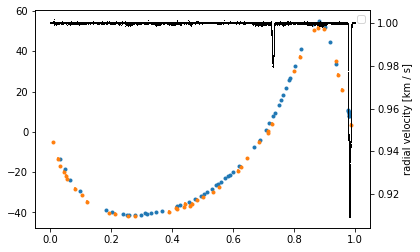

In [11]:
# x_song = np.ascontiguousarray(x_song, dtype=np.float64)
# y_song = np.ascontiguousarray(y_song, dtype=np.float64)

plt.errorbar(rv_song[:,0] % lit_period / lit_period, rv_song[:,1], yerr=rv_song[:,2],fmt='.')
plt.errorbar(rv_bischoff[:,0] % lit_period / lit_period, rv_bischoff[:,1], yerr=rv_bischoff[:,2], fmt='.')

ax2 = plt.twinx()
ax2.plot(time % lit_period / lit_period, flux, ',k')
ax2.set(ylabel='Flux')

plt.legend(fontsize=10)
plt.ylabel("radial velocity [km / s]")
_ = plt.xlabel("time since primary eclipse [days]")

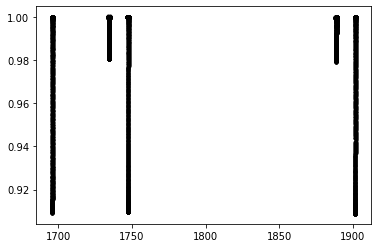

In [12]:
edge = 0.5
m = (
    (time < (lit_t0 + edge)) & (time > (lit_t0 - edge)) |
    (time < (lit_t1 + edge)) & (time > (lit_t1 - edge))
)
for i in range(1, 10):
    m = m | (
        (time < (lit_t0 + lit_period * i + edge)) & (time > (lit_t0 + lit_period * i - edge)) |
        (time < (lit_t1 + lit_period * i + edge)) & (time > (lit_t1 + lit_period * i - edge))
    )
plt.plot(time[m], flux[m], '.k')
time, flux, flux_err = time[m][::], flux[m][::], flux_err[m][::]


In [36]:
def q_to_u(q1, q2):
    return 2*np.sqrt(q1)*q2, np.sqrt(q1)*(1 - 2*q2)

def lc_model(θ, x):
    period, rsum, rratio, incl, sbratio, t0, f_c, f_s, sma, gammava, gammavb, q11, q12, q21, q22, mean, vsini, loglc, logrv_a, logrv_b = θ

    r1, r2 = rsum/(1.+rratio), rsum*rratio/(1.+rratio)
    lc = ellc.lc(x,t_zero=t0,
                radius_1=r1, radius_2=r2,
                incl=incl,
                 vsini_1 = vsini,
                sbratio=sbratio, shape_1='sphere', shape_2='sphere',
                period=period, f_c=f_c, f_s=f_s,
                 # Limb darkening
                ld_1='quad', ld_2='quad', ldc_1=q_to_u(q11,q12), ldc_2=q_to_u(q21,q22),
                a=sma,)
    return lc + mean

def rv_model(θ, x):

    period, rsum, rratio, incl, sbratio, t0, f_c, f_s, sma, gammava, gammavb, q11, q12, q21, q22, mean, vsini, loglc, logrv_a, logrv_b = θ

    r1, r2 = rsum/(1.+rratio), rsum*rratio/(1.+rratio)  
    rv = ellc.rv(x,t_zero=t0,
                radius_1=r1, radius_2=r2,
                incl=incl,
                 vsini_1 = vsini,
                sbratio=sbratio, shape_1='sphere', shape_2='sphere',
                period=period, f_c=f_c, f_s=f_s,
                 # Limb darkening
                ld_1='quad', ld_2='quad', ldc_1=q_to_u(q11,q12), ldc_2=q_to_u(q21,q22),
                a=sma,)
    return rv[0]

def lnprior(θ):
    period, rsum, rratio, incl, sbratio, t0, f_c, f_s, sma, gammava, gammavb, q11, q12, q21, q22, mean, vsini, loglc, logrv_a, logrv_b = θ

    radius_1, radius_2 = rsum/(1.+rratio), rsum*rratio/(1.+rratio)
    prior = 0
    for param, bound in zip(θ, θ_bounds):
        if (bound[0] < param < bound[1]):
            prior += 0
        else:
            return -np.inf
    if (0 < radius_1 < 1) & (0 < radius_2 < 1):
        return prior
    else:
        return -np.inf

def lnlike(θ, time, flux, flux_err, rv_a, rv_b):
    period, rsum, rratio, incl, sbratio, t0, f_c, f_s, sma, gammava, gammavb, q11, q12, q21, q22, mean, vsini, loglc, logrv_a, logrv_b = θ

    if not np.isfinite(lnprior(θ)):
        return -np.inf

    # LC
    model_flux = lc_model(θ, time)
    sigma2 = flux_err ** 2 + model_flux ** 2 * np.exp(2 * loglc)
    ln_lc = -0.5 * np.sum((flux-model_flux)**2/sigma2 + np.log(sigma2))

    model_rv_a = rv_model(θ, rv_a[:,0]) + gammava
    sigma2 = rv_a[:,2] ** 2 + model_rv_a ** 2 * np.exp(2 * logrv_a)
    ln_rv_a = -0.5 * np.sum((rv_a[:,1] - model_rv_a) ** 2 / sigma2 + np.log(sigma2))
    
    model_rv_b = rv_model(θ, rv_b[:,0]) + gammavb
    sigma2 = rv_b[:,2] ** 2 + model_rv_b ** 2 * np.exp(2 * logrv_b)
    ln_rv_b = -0.5 * np.sum((rv_b[:,1] - model_rv_b) ** 2 / sigma2 + np.log(sigma2))
    
    return ln_lc + ln_rv_a + ln_rv_b

def nll(θ, time, flux, flux_err, rv_a, rv_b):
#     print(θ)
    return -lnlike(θ, time, flux, flux_err, rv_a, rv_b)

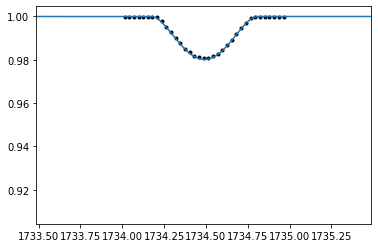

(1695.0199344699147, 1697.0199344699147)

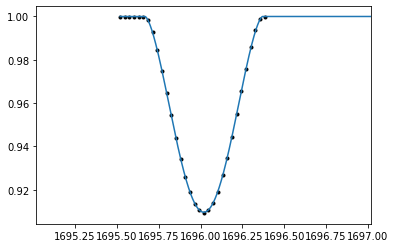

In [37]:
f_c, f_s = 6.19321053e-01, 1.69531989e-01

θ_initial = np.array([
    5.14192040e+01, # Period
    7.17949071e-02, # Rsum
    6.28722905e-01, # Rratio
    8.62150418e+01, # Incl
    6.91829286e-01, # Sbratio
    1.69601971e+03, # t0
    6.20730605e-01, # fc
    1.60481296e-01, # fs
    86, #sma
    -13.53, #gammava
    -13.53, #gammavb
    2.68060970e-01, # q11
    4.55712020e-01, # q12
    8.30538026e-01, # q21
    5.82431661e-02, # q22
    0., # mean
    27, #vsini
    0., #loglc
    0., #logrva
    0., #logrvb
])

θ_bounds = [
    (lit_period-1, lit_period+1), # Period
    (0.01, 0.1), #rsum
    (0.1, 0.9), #rratio
    (45, 90), #incl
    (0.01, 1.5), #sbratio
    (lit_t0-1, lit_t0+1), # T0
    (f_c - 0.1, f_c + 0.1), #fc
    (f_s - 0.1, f_s + 0.1), # fs
    (10, 150.), # sma
    (-20, -5), # gammava
    (-20, -5), # gammavb
    (0., 1.),
    (0., 1.),
    (0., 1.),
    (0., 1.),
    (-0.1, 0.1), #mean
    (26, 28), #vsini
    (-10, 10), #loglc
    (-10, 10), #logrv
    (-10, 10), #logrvb
]

plt.plot(time[::20], flux[::20], '.k')
plt.plot(time, lc_model(θ_initial, time))
plt.xlim(lit_t1-1, lit_t1+1)
plt.show()

plt.plot(time[::20], flux[::20], '.k')
plt.plot(time, lc_model(θ_initial, time))
plt.xlim(lit_t0-1, lit_t0+1)

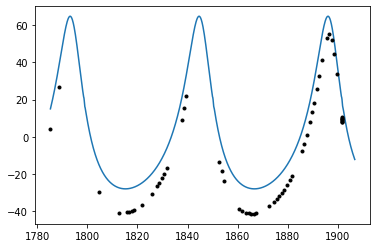

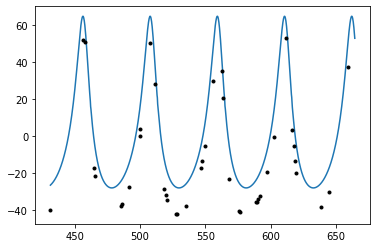

In [38]:
test_time = np.linspace(rv_song[:,0][0], rv_song[:,0][-1]+5, 1000)
plt.plot(test_time, rv_model(θ_initial, test_time))
plt.plot(rv_song[:,0], rv_song[:,1], '.k')
plt.show()

test_time = np.linspace(rv_bischoff[:,0][0], rv_bischoff[:,0][-1]+5, 1000)
plt.plot(test_time, rv_model(θ_initial, test_time))
plt.plot(rv_bischoff[:,0], rv_bischoff[:,1], '.k')

In [39]:
nll(θ_initial, time[::20], flux[::20], flux_err[::20],
      rv_song, rv_bischoff)

302.70158608288614

In [40]:
from scipy.optimize import differential_evolution, minimize

soln = differential_evolution(nll, θ_bounds, args=(time[::20], flux[::20], flux_err[::20],
      rv_song, rv_bischoff), workers=-1)

/home/daniel/anaconda3/envs/ellc/lib/python3.7/site-packages/scipy/optimize/_differentialevolution.py:497: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)
/home/daniel/anaconda3/envs/ellc/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [41]:
soln

     fun: -1327.4254695707932
 message: 'Optimization terminated successfully.'
    nfev: 165663
     nit: 551
 success: True
       x: array([ 5.14187904e+01,  7.27544527e-02,  5.37007241e-01,  8.61823067e+01,
        1.16406671e+00,  1.69602012e+03,  6.06203602e-01,  2.39209471e-01,
        8.92902583e+01, -1.16583989e+01, -1.34739536e+01,  5.69846166e-01,
        6.28316017e-02,  9.47081293e-02,  3.16525717e-01, -8.40852147e-05,
        2.62404499e+01, -7.68334000e+00, -4.72366970e+00, -4.23543830e+00])

In [ ]:
pp = ['period', 'rsum', 'rratio', 'incl', 'sbratio', 't0', 'f_c', 'f_s', 'sma', 'gammav', 'q11', 'q12', 'q21', 'q22', 'loglc', 'mean']

In [45]:
θ_initial = np.array([ 5.14221870e+01,  6.96559105e-02,  4.15510254e-01,  8.64884638e+01,
        9.70322133e-01,  1.69601907e+03,  6.06249065e-01,  2.40106807e-01,
        8.60222114e+01, -1.15555486e+01,  3.17392634e-01,  1.44387715e-01,
        9.53385140e-01,  4.61662394e-01,  -8.00335711e+00,
       -1.39018357e-04, ])

θ_initial = np.array([ 5.14221870e+01,  6.96559105e-02,  4.15510254e-01,  8.64884638e+01,
        9.70322133e-01,  1.69601907e+03,  6.06249065e-01,  2.40106807e-01,
        8.60222114e+01, -1.15555486e+01, -1.34739536e+01,  3.17392634e-01,  1.44387715e-01,
        9.53385140e-01,  4.61662394e-01, -8.40852147e-05,
        2.62404499e+01, -1.39018357e-04, -4.72366970e+00, -4.23543830e+00])

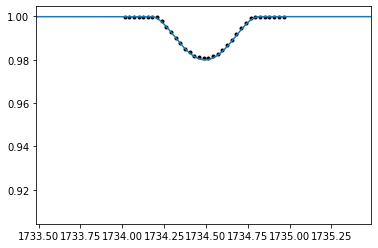

(1695.0199344699147, 1697.0199344699147)

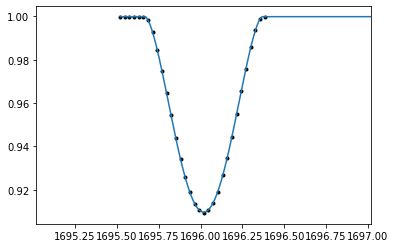

In [46]:
plt.plot(time[::20], flux[::20], '.k')
plt.plot(time, lc_model(θ_initial, time))
plt.xlim(lit_t1-1, lit_t1+1)
plt.show()

plt.plot(time[::20], flux[::20], '.k')
plt.plot(time, lc_model(θ_initial, time))
plt.xlim(lit_t0-1, lit_t0+1)

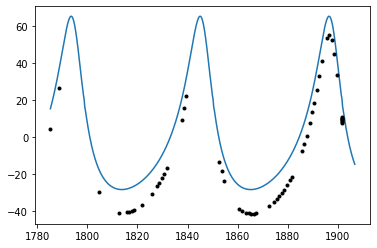

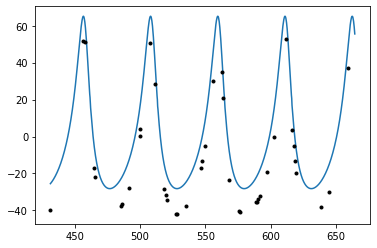

In [47]:
test_time = np.linspace(rv_song[:,0][0], rv_song[:,0][-1]+5, 1000)
plt.plot(test_time, rv_model(θ_initial, test_time))
plt.plot(rv_song[:,0], rv_song[:,1], '.k')
plt.show()

test_time = np.linspace(rv_bischoff[:,0][0], rv_bischoff[:,0][-1]+5, 1000)
plt.plot(test_time, rv_model(θ_initial, test_time))
plt.plot(rv_bischoff[:,0], rv_bischoff[:,1], '.k')

In [15]:
pp = ['period', 'rsum', 'rratio', 'incl', 'sbratio', 't0', 'f_c', 'f_s', 'sma', 'gammav', 'q11', 'q12', 'q21', 'q22', 'loglc', 'mean']

In [33]:
import emcee

pos = θ_initial + 1e-4 * np.random.randn(100, len(θ_initial))
nwalkers, ndim = pos.shape

filename = "ellc_terra_no_q_no_domdt.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(time, flux, flux_err, x_song, y_song, y_song_err))
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(time[::20], flux[::20],flux_err[::20], x_song, y_song, y_song_err), backend=backend)

sampler.run_mcmc(pos, 15000, progress=True);

100%|██████████| 15000/15000 [3:54:13<00:00,  1.07it/s]  


In [16]:
import corner
flat_samples = sampler.get_chain(discard=10000, 
#                                  thin=1÷5, 
                                 flat=True)

In [ ]:
fig = corner.corner(
    flat_samples, labels=pp, 
    show_titles=True, smooth=0.5# truths=[m_true, b_true, np.log(f_true)]
);
plt.savefig('corner_final.png', dpi=300)

In [32]:
# np.savetxt('ellc_terra_flat.txt', flat_samples)

In [13]:
flat_samples = np.loadtxt('ellc_terra_flat.txt')

In [132]:
pp = ['$P$', '$(R_1 + R_2) / a$', '$R_2 / R_1', '$i$', '$S_T$', '$T_0$', '$f_c$', '$f_s$', '$sma$', '$\gamma_v$', '$q_{11}$', '$q_{12}$', '$q_{21}$', '$q_{22}$', 'loglc', 'mean']
pp = ['period', 'rsum', 'rratio', 'incl', 'sbratio', 't0', 'f_c', 'f_s', 'sma', 'gammav', 'q11', 'q12', 'q21', 'q22', 'loglc', 'mean']
for name, sample, bound in zip(pp, flat_samples.T, θ_bounds):
    print(f'{name} & U$\sim${bound} & {np.mean(sample):.3g}\t+/-{np.std(sample):.3}')

period & U$\sim$(50.4213, 52.4213) & 51.4	+/-7.89e-05
rsum & U$\sim$(0.01, 0.1) & 0.0704	+/-0.000473
rratio & U$\sim$(0.1, 0.9) & 0.466	+/-0.0207
incl & U$\sim$(45, 90) & 86.4	+/-0.0471
sbratio & U$\sim$(0.01, 1.5) & 1.03	+/-0.0565
t0 & U$\sim$(1695.0199344699147, 1697.0199344699147) & 1.7e+03	+/-0.000182
f_c & U$\sim$(0.519321053, 0.7193210529999999) & 0.606	+/-0.00199
f_s & U$\sim$(0.06953198899999999, 0.26953198899999997) & 0.238	+/-0.00911
sma & U$\sim$(10, 150.0) & 86.5	+/-0.504
gammav & U$\sim$(-20, -5) & -11.8	+/-0.167
q11 & U$\sim$(0.0, 1.0) & 0.189	+/-0.0737
q12 & U$\sim$(0.0, 1.0) & 0.498	+/-0.263
q21 & U$\sim$(0.0, 1.0) & 0.265	+/-0.206
q22 & U$\sim$(0.0, 1.0) & 0.446	+/-0.281
loglc & U$\sim$(-10, 10) & -7.97	+/-0.0571
mean & U$\sim$(-0.1, 0.1) & -0.000139	+/-4.51e-05


In [114]:
rsum = flat_samples[:,1]
rratio = flat_samples[:,2]
sma = flat_samples[:,8]

r1, r2 = rsum/(1.+rratio), rsum*rratio/(1.+rratio)
np.median(r1 * sma), np.median(r2 * sma), np.std(r1 * sma), np.std(r2 * sma)

(4.153038312568717,
 1.9330092308695894,
 0.05079427860327647,
 0.06843552280893453)

In [130]:
import astropy.units as u
import astropy.constants as c

K = (2 * np.pi / (flat_samples[:,0] * u.day).to(u.s)) * ((flat_samples[:,8]*u.R_sun).to(u.km) * np.sin(np.radians(flat_samples[:,3]))) / np.sqrt(1 - 0.4**2) /2
K = K.value

mf = (flat_samples[:,0] * u.day).to(u.s) * ((K * u.km / u.s).to(u.m/u.s))**3 * (1 - (0.4122996619833249)**2)**(3/2) / (2 * np.pi * c.G)
mf = mf.to(u.Msun)
# np.median(mf)

In [131]:
mf = (4 * np.pi**2 / c.G) * (flat_samples[:,8]/2*u.R_sun).to(u.m)**3 / ((flat_samples[:,0] * u.day).to(u.s))**2
np.median(mf.to(u.M_sun))

<Quantity 0.41004697 solMass>

In [133]:
0.422**(1/3) * 2.8**(2/3)

1.490079721872898

In [25]:
plt.style.use('science')

In [19]:
o_time, o_flux, o_flux_err = np.loadtxt('data/photometry/tess_corrected.txt', usecols=(0,1,2)).T

median_model = lc_model(np.median(flat_samples, axis=0), o_time)
per = np.median(flat_samples, axis=0)[0]
t0 = np.median(flat_samples, axis=0)[5]

In [40]:
overleaf_path = '/Users/daniel/Dropbox (Sydney Uni)/Apps/Overleaf/adra/figs/'

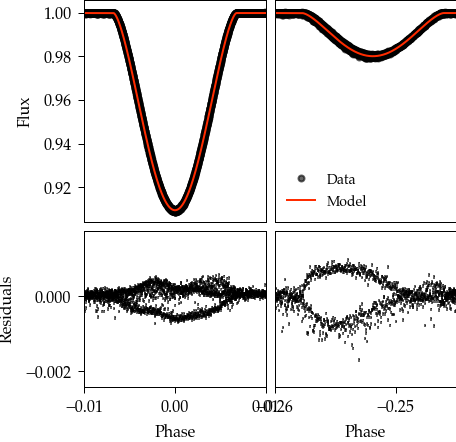

In [94]:
phase = t0 % per / per
fold = (((o_time - phase * per) / per) % 1)
fold[fold > 0.5] -= 1
sort = np.argsort(fold)

fig, axes = plt.subplots(2,2, figsize=[10/3, 3.560113295832983], gridspec_kw={'height_ratios': [1, 0.7]})
axes = axes.flatten()

ax = axes[0]
ax.plot(fold[sort], o_flux[sort], '.k', alpha=0.6, rasterized=True)
ax.plot(fold[sort], median_model[sort], c='C3', lw=1)
ax.set(xlim=[-0.01, 0.01], xticks=[], ylabel='Flux')

ax = axes[2]
ax.errorbar(fold[sort], o_flux[sort] - median_model[sort], yerr=o_flux_err, fmt=',k', alpha=0.6, rasterized=True)
ax.set_xlim(-0.01, 0.01)
ax.set(ylabel='Residuals', xlabel='Phase')

ax = axes[1]
ax.plot(fold[sort], o_flux[sort], '.k', alpha=0.6, rasterized=True, label='Data')
ax.plot(fold[sort], median_model[sort], c='C3', lw=1, label='Model')
ax.set(xlim=[-0.26, -0.245], yticks=[], xticks=[])
ax.legend(fontsize=7)

ax = axes[3]
ax.errorbar(fold[sort], o_flux[sort] - median_model[sort], yerr=o_flux_err, fmt=',k', alpha=0.6, rasterized=True)
ax.set(xlim=[-0.26, -0.245], yticks=[], xlabel='Phase')

plt.subplots_adjust(hspace=0.05, wspace=0.05)

plt.savefig(overleaf_path + 'lc_fit.pdf', dpi=300)

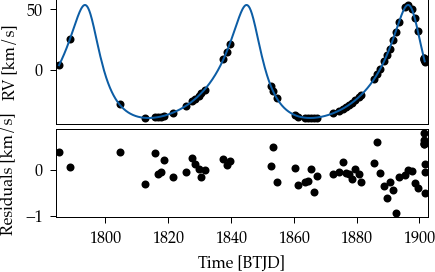

In [93]:
fig, axes = plt.subplots(2, 1, figsize=[10/3, 2.], gridspec_kw={'height_ratios': [1, 0.7]})

ax = axes[0]
synth_x = np.linspace(x_song[0], x_song[-1], 1000)
# median_rv_model = lc_model(np.median(flat_samples, axis=0), x_song)

ax.plot(x_song, y_song, '.k')
ax.plot(synth_x, rv_model(np.median(flat_samples, axis=0), synth_x))
ax.set_xticks([])
ax.set_ylabel('RV [km/s]')
ax.set_xlim(x_song[0]-1, x_song[-1]+1)

ax = axes[1]
ax.errorbar(x_song, y_song -  rv_model(np.median(flat_samples, axis=0), x_song), fmt='.k')
ax.set_xlabel('Time [BTJD]')
ax.set_ylabel('Residuals [km/s]')
ax.set_xlim(x_song[0]-1, x_song[-1]+1)
plt.subplots_adjust(hspace=0.05)

plt.savefig(overleaf_path + 'rv_fit.pdf', dpi=300)